In [445]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import circmean, circstd
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from typing import List
#import h5py
from imaging_behavior_functions import (
    load_intermediate_mat,
    make_df_behavior,
    reconstruct_path,
    get_roi_seq,
    get_roi_seq_2,
    load_dff_raw,
    make_df_neural,
    merge_dataframes,
    fit_sinusoid,
    calculate_theta_g_rho
)
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import entropy
from scipy.signal import welch
from scipy.spatial.distance import pdist, squareform
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

#### Shared processing functions

In [990]:
def compute_event_metrics_3(df, state_col="odor_state", time_col="time", heading_col="heading",  
                            heading_window_size=5, burstiness_window=5, novelty_weight=0.5):
    """
    Computes event-based metrics for both ON and OFF transitions of a binary state variable.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with binary state variable (e.g., odor presence).
    - state_col (str): Name of the binary column indicating event presence (0 or 1).
    - time_col (str): Name of the time column.
    - heading_col (str): Name of the heading column.
    - heading_window_size (float): Time window before an event to average heading.
    - burstiness_window (int): Number of prior intervals to use for burstiness score.
    - novelty_weight (float): Weight factor for novelty score calculation.

    Returns:
    - pd.DataFrame with additional computed columns at both ON and OFF transitions.
    """

    onset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 0) & (df[state_col] == 1)]
    offset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 1) & (df[state_col] == 0)]

    # Initialize new columns
    df["event_duration"] = np.nan
    df["past_interval"] = np.nan
    df["prior_event_duration"] = np.nan
    df["heading_avg"] = np.nan

    # Additional sensory processing metrics
    df["surprise_index"] = np.nan
    df["adaptation_index"] = np.nan
    df["novelty_score"] = np.nan
    df["burstiness_score"] = np.nan

    # Track the last duration separately for ON and OFF events.
    last_on_duration = 0  
    last_off_duration = 0  
    prior_intervals = []  # For burstiness calculation

    all_indices = np.sort(np.concatenate([onset_indices, offset_indices]))  # Ordered events

    for i, event_idx in enumerate(all_indices):
        is_onset = event_idx in onset_indices

        # For an ON event, duration is time until next OFF; for an OFF event, it's until next ON.
        if is_onset:
            matching_offset_idx = offset_indices[offset_indices > event_idx].min()
        else:
            matching_onset_idx = onset_indices[onset_indices > event_idx].min()
        
        # Compute event duration with corrected order for OFF events
        if is_onset and pd.notna(matching_offset_idx):
            event_duration = df.loc[matching_offset_idx, time_col] - df.loc[event_idx, time_col]
        elif (not is_onset) and pd.notna(matching_onset_idx):
            event_duration = df.loc[matching_onset_idx, time_col] - df.loc[event_idx, time_col]
        else:
            event_duration = np.nan

        df.loc[event_idx, "event_duration"] = event_duration

        # Use the last duration from the same event type
        if is_onset:
            df.loc[event_idx, "prior_event_duration"] = last_on_duration
        else:
            df.loc[event_idx, "prior_event_duration"] = last_off_duration

        # Compute past interval (ISI)
        if i > 0:
            prev_event_idx = all_indices[all_indices < event_idx].max()
            past_interval = df.loc[event_idx, time_col] - df.loc[prev_event_idx, time_col]
        else:
            past_interval = df.loc[event_idx, time_col] - df[time_col].iloc[0]
        df.loc[event_idx, "past_interval"] = past_interval
        prior_intervals.append(past_interval)

        # Compute Surprise Index (using past interval)
        df.loc[event_idx, "surprise_index"] = past_interval

        # Use the saved prior event duration for adaptation and novelty
        prior_duration = df.loc[event_idx, "prior_event_duration"]

        # Compute Adaptation Index (ratio of prior event duration to past interval)
        df.loc[event_idx, "adaptation_index"] = np.nan if past_interval == 0 else prior_duration / past_interval

        # Compute Novelty Score (penalizes long prior event durations)
        df.loc[event_idx, "novelty_score"] = past_interval - (novelty_weight * prior_duration)

        # Compute Burstiness Score (variability of past K intervals)
        if len(prior_intervals) > 1:
            windowed_intervals = prior_intervals[max(0, i - burstiness_window):i]
            if len(windowed_intervals) > 1 and np.mean(windowed_intervals) > 0:
                burstiness = np.std(windowed_intervals) / np.mean(windowed_intervals)
            else:
                burstiness = np.nan
        else:
            burstiness = np.nan
        df.loc[event_idx, "burstiness_score"] = burstiness

        # Compute average heading before the event (if available)
        event_time = df.loc[event_idx, time_col]
        window_start_time = event_time - heading_window_size
        heading_window = df[(df[time_col] >= window_start_time) & (df[time_col] < event_time)][heading_col]
        if not heading_window.empty:
            df.loc[event_idx, "heading_avg"] = circmean(heading_window)

        # Update the corresponding last duration based on event type.
        if is_onset:
            last_on_duration = event_duration
        else:
            last_off_duration = event_duration

    # Ensure the first encounter's prior duration is set to 0.
    first_event_idx = all_indices.min()
    if pd.notna(first_event_idx):
        df.loc[first_event_idx, "prior_event_duration"] = 0

    return df


def extract_heatmap(df, roi_kw, roi_kw2):
    if roi_kw2:
        filtered_columns = [col for col in df.columns if roi_kw in col and roi_kw2 not in col]
        roi_mtx = df[filtered_columns]
    else:
        roi_mtx = df[[col for col in df.columns if roi_kw.lower() in col.lower()]]
    if roi_mtx.empty:
        return None
    scaler = StandardScaler()
    roi_mtx = scaler.fit_transform(roi_mtx)
    return roi_mtx

def compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"]):
    """
    For each prefix, computes a new column 'mean_{prefix}'.
    - If both a right and a left column exist (in either format, e.g., '{prefix}R' or '{prefix}_R'),
      their mean is computed.
    - If only one exists, that column's values are used.
    - If neither exists, a message is printed.
    
    Parameters:
        neural_df (pd.DataFrame): DataFrame containing neural measurement columns.
        prefixes (list): List of prefixes for which to compute the mean columns.
        
    Returns:
        pd.DataFrame: The modified DataFrame with new mean columns.
    """
    for prefix in prefixes:
        # Define the possible column names for right and left sides
        possible_right = [f"{prefix}R", f"{prefix}_R"]
        possible_left = [f"{prefix}L", f"{prefix}_L"]
        
        # Check if any of the possible column names exist in the DataFrame
        right_col = next((col for col in possible_right if col in neural_df.columns), None)
        left_col = next((col for col in possible_left if col in neural_df.columns), None)
        mean_col = f"mean_{prefix}"
        
        if right_col and left_col:
            neural_df[mean_col] = (neural_df[right_col] + neural_df[left_col]) / 2
        elif right_col:
            neural_df[mean_col] = neural_df[right_col]
        elif left_col:
            neural_df[mean_col] = neural_df[left_col]
        else:
            print(f"Neither {possible_right} nor {possible_left} found in DataFrame.")
    
    return neural_df


# Example usage:
# neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])

def mean_FB4R(df):
    # Identify columns that contain 'FB4R'
    fb4r_cols = df.columns[df.columns.str.contains('FB4R')]
    # Calculate the row-wise mean for these columns and assign to a new column
    df['mean_FB4R'] = df[fb4r_cols].mean(axis=1)
    return df

def add_dan_mean_columns(df):
    # Identify columns containing "PAM0708"
    pam0708_cols = [col for col in df.columns if "PAM0708" in col]
    if pam0708_cols:
        df["mean_PAM0708"] = df[pam0708_cols].mean(axis=1)
    else:
        df["mean_PAM0708"] = np.nan  # or handle empty case as desired

    # Identify columns containing "MB441" or "PAM12"
    pam12_cols = [col for col in df.columns if ("MB441" in col) or ("PAM12" in col)]
    if pam12_cols:
        df["mean_PAM12"] = df[pam12_cols].mean(axis=1)
    else:
        df["mean_PAM12"] = np.nan

    return df

# Z-score normalization: (trace - mean) / standard deviation
def zscore_normalization(trace):
    mean_val = np.mean(trace)
    std_val = np.std(trace)
    return (trace - mean_val) / std_val

# Min-Max normalization: (trace - min) / (max - min)
def min_max_normalization(trace):
    min_val = np.min(trace)
    max_val = np.max(trace)
    return (trace - min_val) / (max_val - min_val)

# Peak normalization: divide by the maximum value
def peak_normalization(trace):
    peak = np.max(trace)
    return trace / peak if peak != 0 else trace



def add_min_max_normalized_columns(neural_df):
    """
    For each column in neural_df that does not contain 'hDeltaB' or 'EPG', 
    apply min-max normalization and save the result in a new column 
    with the suffix '_minmax'.
    
    Parameters:
        neural_df (pd.DataFrame): Input DataFrame containing neural data.
        
    Returns:
        pd.DataFrame: A new DataFrame with additional min-max normalized columns.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    neural_df_norm = neural_df.copy()
    
    # Identify columns that do not include 'hDeltaB' or 'EPG'
    columns_to_transform = [col for col in neural_df_norm.columns if 'hDeltaB' not in col and 'EPG' not in col and 'time' not in col]
    
    # Loop through each column to transform
    for col in columns_to_transform:
        min_val = neural_df_norm[col].min()
        max_val = neural_df_norm[col].max()
        # Avoid division by zero; if max equals min, set the normalized value to 0.0
        if max_val != min_val:
            neural_df_norm[col + '_minmax'] = (neural_df_norm[col] - min_val) / (max_val - min_val)
        else:
            neural_df_norm[col + '_minmax'] = 0.0
    return neural_df_norm

# Example usage:
# Assuming you have a DataFrame named neural_df:
# neural_df = pd.read_csv("your_data.csv")
# normalized_df = add_min_max_normalized_columns(neural_df)
# print(normalized_df.head())

# make corrections in combined_df
def swap_MBON_columns(df, target_folder="20230817-3_MBON09_GCAMP7f_odor_apple_patchy_fly2"):
    """
    For rows in the DataFrame where 'folder_name' matches the target_folder,
    swap the values between the following column pairs:
        - MBON21R and MBON09R
        - MBON21L and MBON09L
        - mean_MBON21 and mean_MBON09

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_folder (str): The folder_name string used to filter rows.
                             Default is "20230817-3_MBON09_GCAMP7f_odor_apple_patchy_fly2".

    Returns:
        pd.DataFrame: The DataFrame with swapped columns for the filtered rows.
    """
    mask = df['folder_name'] == target_folder
    
    # Swap the columns for the filtered rows
    df.loc[mask, ['MBON21R', 'MBON09R']] = df.loc[mask, ['MBON09R', 'MBON21R']].values
    df.loc[mask, ['MBON21L', 'MBON09L']] = df.loc[mask, ['MBON09L', 'MBON21L']].values
    df.loc[mask, ['mean_MBON21', 'mean_MBON09']] = df.loc[mask, ['mean_MBON09', 'mean_MBON21']].values
    df.loc[mask, ['mean_MBON21_minmax', 'mean_MBON09_minmax']] = df.loc[mask, ['mean_MBON09_minmax', 'mean_MBON21_minmax']].values
    
    return df

def gaussian_smooth(column, sigma):
    """Applies Gaussian smoothing to a dataframe column.

    Args:
        column (pd.Series): The column to smooth.
        sigma (float): The standard deviation of the Gaussian kernel.

    Returns:
        pd.Series: Smoothed column.
    """
    from scipy.ndimage import gaussian_filter1d

    smoothed = gaussian_filter1d(column.values, sigma=sigma)
    return pd.Series(smoothed, index=column.index)


def plot_neural_activity_2(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],
                         sigma=None, plot_kw='interval', is_onset = True,bounds=[10, 25, 100, 200], velocity_threshold=0):
    
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")
    
    if "time" not in df.columns or "fwV" not in df.columns:
        raise ValueError("Columns 'time' or 'fwV' not found in the dataframe.")

    # Apply Gaussian smoothing if needed
    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_smooth(df[column], sigma)

    # Find odor onset times
    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]

    fig, axs = plt.subplots(len(plot_columns), 2, figsize=(12, 4 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces_slow = []
        aligned_traces_fast = []
        trace_colors_slow = []
        trace_colors_fast = []

        # Use smoothed column if sigma is provided
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets)-1):
            onset = odor_onsets[j]
            start = max(0, onset - pre_window_size)
            end = min(len(df), onset + post_window_size)

            # Compute average pre-window forward velocity
            pre_window_fwd_velocity = df["fwV_smoothed"].iloc[start:onset].mean()

            # Extract trace and corresponding time centered around odor onset
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[onset]

            if np.array(time_trace)[-1] > 0:  # Ensure trace is long enough
                if pre_window_fwd_velocity < velocity_threshold:
                    aligned_traces_slow.append((time_trace.reset_index(drop=True), trace))
                else:
                    aligned_traces_fast.append((time_trace.reset_index(drop=True), trace))

                # Determine color based on plot_kw
                if plot_kw == "duration":
                    value = df.loc[onset, "odor_duration"]
                elif plot_kw == "interval":
                    value = df.loc[onset, "past_interval"]
                else:
                    value = None
                
                if value is not None:
                    if pre_window_fwd_velocity < velocity_threshold:
                        trace_colors_slow.append(value)
                    else:
                        trace_colors_fast.append(value)

        # Compute colormap normalization
        all_trace_colors = trace_colors_slow + trace_colors_fast
        if all_trace_colors:
            norm = plt.Normalize(min(all_trace_colors), max(all_trace_colors))
            cmap = plt.cm.rainbow

        # Helper function to group traces based on bounds
        def group_traces_by_bounds(aligned_traces, trace_colors, bounds):
            grouped_traces = {str(i): [] for i in range(len(bounds) + 1)}

            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                elif bounds[0] <= value <= bounds[1]:
                    grouped_traces["1"].append(aligned_traces[idx][1])
                elif bounds[1] < value <= bounds[2]:
                    grouped_traces["2"].append(aligned_traces[idx][1])
                elif bounds[2] < value <= bounds[3]:
                    grouped_traces["3"].append(aligned_traces[idx][1])
                else:
                    grouped_traces["4"].append(aligned_traces[idx][1])

            # Remove empty groups to prevent errors
            grouped_traces = {k: v for k, v in grouped_traces.items() if v}

            return grouped_traces


        # Group traces by bounds
        grouped_traces_slow = group_traces_by_bounds(aligned_traces_slow, trace_colors_slow, bounds)
        grouped_traces_fast = group_traces_by_bounds(aligned_traces_fast, trace_colors_fast, bounds)

        # Plot traces for slow and fast trials
        for group, traces in grouped_traces_slow.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_slow[idx] for idx, value in enumerate(trace_colors_slow) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")

        for group, traces in grouped_traces_fast.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_fast[idx] for idx, value in enumerate(trace_colors_fast) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i + 1].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
        # Plot traces for slow trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_slow):
            color = cmap(norm(trace_colors_slow[idx])) if trace_colors_slow else "blue"
            axs[2 * i].plot(time_trace, trace, alpha=0.01, color=color)

        # Plot traces for fast trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_fast):
            color = cmap(norm(trace_colors_fast[idx])) if trace_colors_fast else "blue"
            axs[2 * i + 1].plot(time_trace, trace, alpha=0.05, color=color)
        # Add odor onset line
        axs[2 * i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        axs[2 * i + 1].axvline(x=0, color='red', linestyle='--', label='Odor Onset')

        # Titles and labels
        axs[2 * i].set_title(f"{column} - Slow Trials (< {velocity_threshold} cm/s)")
        axs[2 * i + 1].set_title(f"{column} - Fast Trials (>= {velocity_threshold} cm/s)")
        axs[2 * i].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i + 1].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i].set_ylabel("Activity")
        #axs[2 * i].set_ylim([])
        axs[2 * i + 1].set_ylabel("Activity")

    plt.tight_layout()
    plt.show()


def plot_neural_activity(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"], sigma=None, plot_kw='past_interval', is_onset=True, bounds=[10, 25, 100, 200],percentile_range=[0, 100]):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    odor_offsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets) - 1):
            onset = odor_onsets[j]
            offset = odor_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.1, color=color)

        grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
        
        for idx, value in enumerate(trace_colors):
            if value < bounds[0]:
                grouped_traces["0"].append(aligned_traces[idx][1])
            else:
                for b_idx in range(1, len(bounds)):
                    if bounds[b_idx - 1] <= value < bounds[b_idx]:
                        grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                        break
                else:
                    grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
        
        for group, traces in grouped_traces.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                
                group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                if (value < bounds[0] and group == "0") or
                                any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                (value >= bounds[-1] and group == str(len(bounds)))]
                
                if group_values:
                    group_avg = np.mean(group_values)
                    color = cmap(norm(group_avg))
                    axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
     
        
        axs[i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to odor {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
    
    plt.tight_layout()
    plt.show()


def plot_neural_activity_zero(df, pre_window_size, post_window_size, 
                                plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],
                                sigma=None, plot_kw='past_interval', is_onset=True, 
                                bounds=[10, 25, 100, 200], percentile_range=[0, 100],
                                baseline_duration=1,onset_shift=0.6):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    odor_offsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets) - 1):
            onset = odor_onsets[j]
            offset = odor_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]
            # Shift time axis for plotting so that odor onset appears at onset_shift seconds
            time_trace = time_trace + onset_shift
            time_trace = time_trace.reset_index(drop=True)

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                # Baseline subtraction: subtract the mean of the fixed prestimulus period 
                # (only using points within the last `baseline_duration` seconds before time zero)
                baseline = trace[(time_trace < 0) & (time_trace >= -baseline_duration)].mean()
                trace = trace - baseline
                
                aligned_traces.append((time_trace, trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        #for idx, (time_trace, trace) in enumerate(aligned_traces):
            #color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            #axs[i].plot(time_trace, trace, alpha=0.1, color=color)
        grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
        
        for idx, value in enumerate(trace_colors):
            if value < bounds[0]:
                grouped_traces["0"].append(aligned_traces[idx][1])
            else:
                for b_idx in range(1, len(bounds)):
                    if bounds[b_idx - 1] <= value < bounds[b_idx]:
                        grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                        break
                else:
                    grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
        
        for group, traces in grouped_traces.items():
            if traces:
                trace_df = pd.DataFrame(traces)
                mean_trace = trace_df.mean()
                stderr = trace_df.std() / np.sqrt(len(traces))
                mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                
                group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                if (value < bounds[0] and group == "0") or
                                any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                (value >= bounds[-1] and group == str(len(bounds)))]
                
                if group_values:
                    group_avg = np.mean(group_values)
                    color = cmap(norm(group_avg))
                    axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
                    axs[i].fill_between(time_trace, mean_trace - stderr, mean_trace + stderr, 
                                          color=color, alpha=0.3, linewidth=0)
     
        axs[i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to odor {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
        if column == 'mean_MBON09' and is_onset:
            axs[i].set_ylim(-0.15, 0.4)
        if column == 'mean_MBON09' and not is_onset:
            axs[i].set_ylim(-0.2, 0.35)
        if column == 'mean_MBON21' and is_onset:
            axs[i].set_ylim(-0.25, 0.3)
        if column == 'mean_MBON21' and not is_onset:
            axs[i].set_ylim(-0.15, 0.4)
        
    
    plt.tight_layout()
    plt.show()


def circular_mode(circular_data, method='kde', bins=360, num_bins=30):
    """
    Calculate the mode angle of circular data using either Kernel Density Estimation (KDE) or histogram binning.

    Parameters:
    -----------
    circular_data : array-like
        Array of angles in radians, expected to be in range [0, 2π].
    method : str, optional
        Method to use for calculating the mode. Options:
        - 'kde' (default) : Uses Kernel Density Estimation (KDE).
        - 'histogram' : Uses histogram binning.
    bins : int, optional
        Number of bins for KDE estimation (default: 360).
    num_bins : int, optional
        Number of bins for histogram binning (default: 30).

    Returns:
    --------
    float
        Mode angle in radians.
    """
    if method == 'kde':
        # Kernel Density Estimation method
        density = gaussian_kde(circular_data)
        x = np.linspace(0, 2*np.pi, bins)  # Range from 0 to 2π
        y = density(x)
        peaks, _ = find_peaks(y)
        if len(peaks) == 0:
            return None  # No peaks found
        mode_idx = peaks[np.argmax(y[peaks])]
        return x[mode_idx]

    elif method == 'histogram':
        # Histogram binning method
        n, bin_edges = np.histogram(circular_data, bins=num_bins, range=(0, 2*np.pi))
        max_bin_index = np.argmax(n)
        mode_angle = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
        return mode_angle

    else:
        raise ValueError("Invalid method. Choose 'kde' or 'histogram'.")


def plot_tuning_curve(df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], num_bins=10, percentile_low=5, percentile_high=95):
    """Plots tuning curves for given ROIs against specified behavioral variables."""
    if isinstance(rois, str):
        rois = [rois]
    
    for roi in rois:
        if roi not in df.columns or df[roi].isna().all():
            print(f"ROI '{roi}' does not exist or contains only NaNs.")
            continue
        
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(5 * len(behavioral_vars), 4))
        if len(behavioral_vars) == 1:
            axes = [axes]
        
        for ax, var in zip(axes, behavioral_vars):
            if var not in df.columns:
                print(f"Behavioral variable '{var}' not found in DataFrame.")
                continue
            
            temp_df = df.copy()
            if var == 'fwV':
                # Apply percentile cutoffs
                low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
                temp_df = temp_df[(temp_df[var] >= low) & (temp_df[var] <= high)]
            if var == 'absyawV':
                # Apply percentile cutoffs
                low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
                temp_df = temp_df[temp_df[var] <= high]
            if var == 'heading':
                # Handle circular data
                temp_df = temp_df.dropna(subset=['heading', roi])
                angles = temp_df['heading']  # Already in radians
                circ_mode = circular_mode(angles,method='histogram')
                transformed_heading = np.angle(np.exp(1j * (angles - circ_mode)))  # Circular difference
                temp_df['transformed_heading'] = transformed_heading
                
                bins = np.linspace(-np.pi, np.pi, num_bins + 1)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                temp_df['heading_bin'] = pd.cut(temp_df['transformed_heading'], bins, labels=bin_centers, include_lowest=True)
                grouped = temp_df.groupby('heading_bin')[roi].mean()
                ax.plot(grouped.index.astype(float), grouped.values, marker='o')
                ax.set_xlabel('Transformed Heading (radians)')
                ax.set_title(f'{roi} vs Transformed Heading')
            else:
                # Non-circular variables
                temp_df = temp_df.dropna(subset=[var, roi])
                bins = np.linspace(temp_df[var].min(), temp_df[var].max(), num_bins + 1)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                temp_df[f'{var}_bin'] = pd.cut(temp_df[var], bins, labels=bin_centers, include_lowest=True)
                grouped = temp_df.groupby(f'{var}_bin')[roi].mean()
                ax.plot(grouped.index.astype(float), grouped.values, marker='o')
                ax.set_xlabel(var)
                ax.set_title(f'{roi} vs {var}')
            
            ax.set_ylabel(roi)
        
        plt.tight_layout()
        plt.show()

def plot_tuning_curve_zeroed(ax, df, roi, var, num_bins=10, percentile_low=5, percentile_high=95):
    """Plots tuning curve for a given ROI against a behavioral variable on a given axis."""
    temp_df = df.copy()
    if var == 'fwV':
                # Apply percentile cutoffs
                low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
                temp_df = temp_df[(temp_df[var] >= low) & (temp_df[var] <= high)]
    if var == 'absyawV':
        # Apply percentile cutoffs
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[temp_df[var] <= high]
    if var == 'heading':
        # Handle circular data
        temp_df = temp_df.dropna(subset=['heading', roi])
        angles = temp_df['heading']  # Already in radians
        circ_mode = circular_mode(angles, method='histogram',num_bins=num_bins)
        transformed_heading = np.abs(np.angle(np.exp(1j * (angles - circ_mode))))  # Circular difference
        temp_df['transformed_heading'] = transformed_heading
        
        bins = np.linspace(0, np.pi, num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df['heading_bin'] = pd.cut(temp_df['transformed_heading'], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby('heading_bin', observed=True)[roi].mean()
    else:
        # Non-circular variables
        temp_df = temp_df.dropna(subset=[var, roi])
        bins = np.linspace(temp_df[var].min(), temp_df[var].max(), num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    
    # Zero y-axis at the bin center closest to x = 0
    #print(bin_centers)
    zero_index = np.argmin(np.abs(bin_centers))
    y_offset = grouped.iloc[zero_index] if len(grouped) > zero_index else 0
    
    ax.plot(grouped.index.astype(float), grouped.values - y_offset,  color = 'blue', alpha=0.2,  label=f'Fly {temp_df.flyid.unique()[0]}')
    ax.set_xlabel(var if var != 'heading' else 'Transformed Heading (radians)')
    ax.set_ylabel(roi)
    #ax.legend()


def plot_tuning_curve_zeroed_2(ax, df, roi, var, num_bins=10, percentile_low=5, percentile_high=95,
                             apply_smoothing=True, smooth_window=5, smooth_polyorder=2,plot_color='blue'):
    """Plots tuning curve for a given ROI against a behavioral variable on a given axis,
    with optional smoothing using a Savitzky-Golay filter.
    
    Parameters:
        ax: matplotlib axis to plot on.
        df: DataFrame containing the data.
        roi: Column name for the region of interest.
        var: Behavioral variable to bin and plot against.
        num_bins: Number of bins to use.
        percentile_low: Lower percentile for cutoff (for fwV, absyawV).
        percentile_high: Upper percentile for cutoff.
        apply_smoothing: If True, applies Savitzky-Golay smoothing to the curve.
        smooth_window: Window length for the smoothing filter (must be odd).
        smooth_polyorder: Polynomial order for the smoothing filter.
    """

    temp_df = df.copy()
    
    if var == 'fwV':
        # Apply percentile cutoffs
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[(temp_df[var] >= low) & (temp_df[var] <= high)]
    if var == 'absyawV':
        # Apply percentile cutoffs
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[temp_df[var] <= high]
        
    if var == 'heading':
        # Handle circular data
        temp_df = temp_df.dropna(subset=['heading', roi])
        angles = temp_df['heading']  # Already in radians
        circ_mode = circular_mode(angles, method='histogram', num_bins=num_bins)
        transformed_heading = np.abs(np.angle(np.exp(1j * (angles - circ_mode))))  # Circular difference
        temp_df['transformed_heading'] = transformed_heading
        
        bins = np.linspace(0, np.pi, num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df['heading_bin'] = pd.cut(temp_df['transformed_heading'], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby('heading_bin', observed=True)[roi].mean()
    else:
        # Non-circular variables
        temp_df = temp_df.dropna(subset=[var, roi])
        bins = np.linspace(temp_df[var].min(), temp_df[var].max(), num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    
    # Zero y-axis at the bin center closest to x = 0
    zero_index = np.argmin(np.abs(bin_centers))
    y_offset = grouped.iloc[zero_index] if len(grouped) > zero_index else 0

    # Prepare x and y values for plotting
    x_values = grouped.index.astype(float)
    y_values = grouped.values - y_offset

    # Plot the original (unsmoothed) curve with low opacity
    #ax.plot(x_values, y_values, color='blue', alpha=0.2, label=f'Fly {temp_df.flyid.unique()[0]}')
    
    # Apply smoothing if desired and if there are enough points
    if apply_smoothing and len(y_values) >= smooth_window:
        # Ensure window length is odd
        if smooth_window % 2 == 0:
            smooth_window += 1
        y_smooth = savgol_filter(y_values, smooth_window, smooth_polyorder)
        ax.plot(x_values, y_smooth, color=plot_color, alpha=0.4, label='Smoothed')
    else:
        # If smoothing is disabled or there aren't enough points, plot original values in red
        ax.plot(x_values, y_values, color=plot_color, alpha=0.4, label='No Smoothing Applied')
    
    ax.set_xlabel(var if var != 'heading' else 'Transformed Heading (radians)')
    ax.set_ylabel(roi)


def plot_tuning_curve_zeroed_4(ax, df, roi, var, num_bins=10, percentile_low=5, percentile_high=95,
                               apply_smoothing=True, smooth_window=5, smooth_polyorder=2, plot_color='blue'):
    """
    Plots tuning curve for a given ROI against a behavioral variable on a given axis,
    with optional smoothing using a Savitzky-Golay filter.
    
    Parameters:
        ax: matplotlib axis to plot on.
        df: DataFrame containing the data.
        roi: Column name for the region of interest.
        var: Behavioral variable to bin and plot against.
        num_bins: Number of bins to use.
        percentile_low: Lower percentile for cutoff (for fwV, absyawV).
        percentile_high: Upper percentile for cutoff.
        apply_smoothing: If True, applies Savitzky-Golay smoothing to the curve.
        smooth_window: Window length for the smoothing filter (must be odd).
        smooth_polyorder: Polynomial order for the smoothing filter.
        plot_color: Color to use for plotting.
    """

    temp_df = df.copy()
    
    # If the requested variable is entirely NaN, exit without plotting.
    if temp_df[var].dropna().empty:
        return

    # Apply percentiles for non-circular variables fwV and absyawV
    if var == 'fwV':
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[(temp_df[var] >= low) & (temp_df[var] <= high)]
    if var in ['absyawV', 'amplitude', 'baseline']:
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[temp_df[var] <= high]
        
    # Process circular variables: heading and phase
    if var in ['heading', 'phase']:
        # Drop rows missing either the variable or ROI
        temp_df = temp_df.dropna(subset=[var, roi])
        angles = temp_df[var]  # Assumed to be in radians
        # Compute the circular mode (assumes circular_mode is defined elsewhere)
        circ_mode = circular_mode(angles, method='histogram', num_bins=num_bins)
        # Compute the circular difference from the mode
        transformed = np.abs(np.angle(np.exp(1j * (angles - circ_mode))))
        new_var = f"transformed_{var}"
        temp_df[new_var] = transformed
        
        # Bin the transformed values over [0, pi]
        bins = np.linspace(0, np.pi, num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[new_var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    else:
        # Non-circular variables: simply drop missing values and bin
        temp_df = temp_df.dropna(subset=[var, roi])
        bins = np.linspace(temp_df[var].min(), temp_df[var].max(), num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    
    # Zero the y-axis by subtracting the value at the bin closest to x=0
    zero_index = np.argmin(np.abs(bin_centers))
    y_offset = grouped.iloc[zero_index] if len(grouped) > zero_index else 0
    #y_offset = 0

    # Prepare x and y values for plotting
    x_values = grouped.index.astype(float)
    y_values = grouped.values - y_offset

    # Apply smoothing if desired and if enough points exist
    if apply_smoothing and len(y_values) >= smooth_window:
        # Ensure the smoothing window length is odd
        if smooth_window % 2 == 0:
            smooth_window += 1
        y_smooth = savgol_filter(y_values, smooth_window, smooth_polyorder)
        ax.plot(x_values, y_smooth, color=plot_color, alpha=0.4, label='Smoothed')
    else:
        # Plot original values if smoothing is disabled or insufficient points
        ax.plot(x_values, y_values, color=plot_color, alpha=0.4, label='No Smoothing Applied')
    
    # Set x-axis label: use transformed label for circular variables
    if var in ['heading', 'phase']:
        ax.set_xlabel(f"Transformed {var.capitalize()} (radians)")
    else:
        ax.set_xlabel(var)
    ax.set_ylabel(roi)
    #ax.set_ylim(-0.3, 0.65)


def plot_tuning_curve_wrapper(combined_df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], 
                              num_bins=20, percentile_low=1, percentile_high=99, plot_column='rho_t'):
    """
    Loops through unique combinations of flyid and trialid and plots tuning curves for each ROI and behavioral variable.
    For each fly-trial subset (df_trial), the plot color is determined by mapping the mean of its 'rho_t' column 
    to a color spectrum using a colormap.
    """
    import matplotlib as mpl

    # Create a normalization object based on the global rho_t range
    norm = mpl.colors.Normalize(vmin=combined_df[plot_column].min(), vmax=combined_df[plot_column].max())
    cmap = plt.cm.viridis  # Choose any colormap you prefer

    # Get unique combinations of flyid and trialid
    unique_fly_trials = combined_df[['flyid', 'trialid']].drop_duplicates()

    for roi in rois:
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(5 * len(behavioral_vars), 4))
        if len(behavioral_vars) == 1:
            axes = [axes]
        
        for ax, var in zip(axes, behavioral_vars):
            for flyid, trialid in unique_fly_trials.values:
                # Filter the DataFrame for the current flyid and trialid combination
                df_trial = combined_df[(combined_df.flyid == flyid) & (combined_df.trialid == trialid)]
                if roi in df_trial.columns and not df_trial[roi].isna().all():
                    # Compute the mean of rho_t for this fly-trial subset
                    rho_mean = np.mean(df_trial[plot_column])
                    # Map the mean value to a color in the colormap
                    plot_color = cmap(norm(rho_mean))
                    
                    # Call the tuning curve plotting function with the computed color
                    plot_tuning_curve_zeroed_2(ax, df_trial, roi, var, num_bins, 
                                               percentile_low, percentile_high, plot_color=plot_color,apply_smoothing=True)
            ax.set_title(f'{roi} vs {var}')
        
        # Create a scalar mappable for the colorbar and add it to the right side of the figure.
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Adjust the figure to make space for the colorbar
        fig.subplots_adjust(right=0.85)
        # Create an axis for the colorbar on the right side of the figure
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
        fig.colorbar(sm, cax=cbar_ax, label=f'Mean {plot_column}')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_circular_tuning(ax, df, neural_activity_col, circular_var, num_bins=20, 
                         colors=None, apply_smoothing=False, smoothing_sigma=1,
                         diff_threshold=0.3, thick_line_width=1.5, default_line_width=1):
    """
    Plot circular tuning curves on a standard (Cartesian) axis for one or multiple pairs of neural activity 
    and circular variables using a bin-and-average strategy with min–max scaling.
    
    The circular variable is shifted so that its mode (computed via circular_mode) is aligned at π.
    That is:
    
         shifted_angle = mod(original_angle - mode_angle + π, 2π)
    
    A vertical dotted line at x = π is added to indicate the modal heading.
    In addition, the raw difference between the binned neural activity's min and max is computed.
    If this difference is above `diff_threshold`, the curve is plotted with a thicker line.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axis on which to plot.
    df : pandas.DataFrame
        DataFrame containing the data.
    neural_activity_col : str or list of str
        Column name(s) for neural activity data.
    circular_var : str or list of str
        Column name(s) for the circular variable (in radians, [0, 2π]).
    num_bins : int, optional
        Number of bins to use for averaging (default is 20).
    colors : str or list of str, optional
        Color(s) for plotting. If a single string is provided, that color is used for all curves.
    apply_smoothing : bool, optional
        If True, smooth the binned data using a Gaussian filter (default is False).
    smoothing_sigma : float, optional
        Standard deviation for the Gaussian kernel used for smoothing (default is 1).
    diff_threshold : float, optional
        Threshold for the raw difference (max_val - min_val) for each curve.
        If the difference exceeds this threshold, the curve is plotted with a thicker line.
        (Default is 0.5)
    thick_line_width : float, optional
        Line width for curves with a raw range above diff_threshold (default is 3).
    default_line_width : float, optional
        Line width for curves with a raw range below diff_threshold (default is 1.5).
    
    Notes:
    ------
    - Assumes the existence of a helper function `circular_mode` that computes the circular mode of the data.
    - If lists are provided for neural_activity_col and circular_var, they must have the same length.
    - For each pair, the circular variable is shifted, binned, averaged, and min–max scaled to [0, 1].
      Optionally, smoothing is applied.
    - A vertical dotted line is drawn at π to indicate the modal heading.
    - A legend is added if more than one tuning curve is plotted.
    """
    # Ensure neural_activity_col and circular_var are lists.
    if isinstance(neural_activity_col, list) and isinstance(circular_var, list):
        if len(neural_activity_col) != len(circular_var):
            raise ValueError("neural_activity_col and circular_var lists must have the same length.")
    elif isinstance(neural_activity_col, list) and not isinstance(circular_var, list):
        circular_var = [circular_var] * len(neural_activity_col)
    elif not isinstance(neural_activity_col, list) and isinstance(circular_var, list):
        neural_activity_col = [neural_activity_col] * len(circular_var)
    else:
        neural_activity_col = [neural_activity_col]
        circular_var = [circular_var]
    
    # Process colors: if not provided, use default (None) for each curve.
    num_curves = len(neural_activity_col)
    if colors is None:
        colors = [None] * num_curves
    elif isinstance(colors, list):
        if len(colors) != num_curves:
            raise ValueError("Length of colors list must match the number of tuning curves.")
    else:  # a single color string is provided; use it for all curves.
        colors = [colors] * num_curves

    # Define common bin edges and centers for the range [0, 2π].
    bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Loop over each pair of columns and plot the tuning curve.
    for i, (na_col, circ_col) in enumerate(zip(neural_activity_col, circular_var)):
        # Compute the circular mode for the current circular variable.
        mode_angle = circular_mode(df[circ_col])
        # Shift the circular variable so that its mode is aligned at π.
        shifted_angles = np.mod(df[circ_col] - mode_angle + np.pi, 2 * np.pi)
        
        # Copy the DataFrame and add the shifted angle.
        df_temp = df.copy()
        df_temp['shifted_angle'] = shifted_angles
        
        # Digitize the shifted angles into bins.
        df_temp['bin'] = np.digitize(df_temp['shifted_angle'], bin_edges, right=False) - 1
        df_temp['bin'] = df_temp['bin'].clip(0, num_bins - 1)
        
        # Compute the average neural activity in each bin.
        bin_means = df_temp.groupby('bin')[na_col].mean()
        # Reindex to ensure every bin is represented.
        bin_means = bin_means.reindex(range(num_bins), fill_value=np.nan)
        
        # Calculate the raw range before scaling.
        raw_range = bin_means.max() - bin_means.min()
        
        # Apply min–max scaling to the binned values.
        min_val = bin_means.min()
        max_val = bin_means.max()
        if max_val - min_val != 0:
            bin_means_scaled = (bin_means - min_val) / (max_val - min_val)
        else:
            bin_means_scaled = bin_means - min_val  # All values are equal; set them to 0.
        
        # Optionally smooth the binned data.
        if apply_smoothing:
            bin_means_scaled = gaussian_filter1d(bin_means_scaled, sigma=smoothing_sigma, mode='wrap')
        
        # Set line width based on raw_range.
        if raw_range > diff_threshold:
            lw = thick_line_width
            ap = 0.3
        else:
            lw = thick_line_width
            ap = 0.3
        
        # Plot the tuning curve on a standard Cartesian axis.
        ax.plot(bin_centers, bin_means_scaled,
                color=colors[i], linewidth=lw, alpha=ap,label=f"{na_col} vs {circ_col}")
    
    # Add a vertical dotted line at π to indicate the modal heading.
    ax.axvline(np.pi, color='k', linestyle='--', linewidth=1, label='Modal Heading')
    
    # Set axis properties.
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel('Shifted Angle (rad)')
    ax.set_ylabel('Normalized Neural Activity')
    #ax.set_title('Circular Tuning Curve (Binned, Scaled, Aligned to π)')
    #ax.grid(True)
    
    # Add a legend.
    #ax.legend()


def plot_tuning_curve_wrapper_2(combined_df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], 
                              num_bins=20, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True, color_map=plt.cm.viridis):
    """
    Loops through unique combinations of flyid and trialid and plots tuning curves for each ROI and behavioral variable.
    For each fly-trial subset, a plotting variable is calculated to determine the curve's color.
    
    Parameters:
      combined_df (DataFrame): DataFrame containing your data.
      rois (list): List of regions of interest.
      behavioral_vars (list): List of behavioral variable names to plot.
      num_bins (int): Number of bins for the tuning curve.
      percentile_low (float): Lower percentile for data trimming.
      percentile_high (float): Upper percentile for data trimming.
      plot_column (str): Column name to use if no custom plotting function is provided.
      plot_var_func (callable): A function that takes a DataFrame (for a flyid/trialid subset) and returns a numeric value.
                                If None, the mean of `plot_column` will be used.
      plot_label (str): Label for the colorbar. If None, a default is generated.
      apply_smoothing (bool): Whether to apply smoothing in the tuning curve plotting function.
    
    The color for each curve is computed by mapping the plotting variable value to a colormap whose range is defined
    by the global min and max of the calculated values.
    """
    import matplotlib as mpl

    # Get unique combinations of flyid and trialid
    unique_fly_trials = combined_df[['flyid', 'trialid']].drop_duplicates()

    # Precompute the plotting variable for each flyid/trialid combination
    plot_val_dict = {}
    for flyid, trialid in unique_fly_trials.values:
        df_trial = combined_df[(combined_df.flyid == flyid) & (combined_df.trialid == trialid)]
        if plot_var_func is not None:
            val = plot_var_func(df_trial)
        else:
            val = np.mean(df_trial[plot_column])
        plot_val_dict[(flyid, trialid)] = val

    # Define the global range for color normalization based on the calculated variable values
    #print(plot_val_dict)
    global_min = min(plot_val_dict.values())
    global_min = 0.43
    #print(global_min)
    global_max = max(plot_val_dict.values())
    #print(global_max)
    global_max = 0.97
    norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
    cmap = color_map  # Choose any colormap you prefer

    # Set a default colorbar label if not provided
    #if plot_label is None:
        #plot_label = f'Mean {plot_column}' if plot_var_func is None else 'Plot Variable'

    # Loop over ROIs and behavioral variables to create plots
    for roi in rois:
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(5 * len(behavioral_vars), 4))
        if len(behavioral_vars) == 1:
            axes = [axes]

        for ax, var in zip(axes, behavioral_vars):
            for flyid, trialid in unique_fly_trials.values:
                # Filter the DataFrame for the current flyid/trialid combination
                df_trial = combined_df[(combined_df.flyid == flyid) & (combined_df.trialid == trialid)]
                if roi in df_trial.columns and not df_trial[roi].isna().all():
                    # Retrieve the precomputed plotting variable value
                    val = plot_val_dict[(flyid, trialid)]
                    # Map the value to a color using the global normalization
                    plot_color = cmap(norm(val))

                    # Call the tuning curve plotting function with the computed color
                    plot_tuning_curve_zeroed_4(ax, df_trial, roi, var, num_bins, 
                                               percentile_low, percentile_high, 
                                               plot_color=plot_color, apply_smoothing=apply_smoothing)
                    #plot_circular_tuning(ax, df_trial,roi,var,num_bins,colors=plot_color, apply_smoothing=apply_smoothing)
            ax.set_title(f'{roi} vs {var}')
            if roi == 'mean_MBON09' and var == 'phase':
                ax.set_ylim(-0.1,0.6)
            if roi == 'mean_MBON21' and var == 'phase':
                ax.set_ylim(-0.6,0.1)

        # Create a scalar mappable for the colorbar and add it to the right side of the figure.
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Adjust the figure to make space for the colorbar
        fig.subplots_adjust(right=0.85)
        # Create an axis for the colorbar on the right side of the figure
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
        fig.colorbar(sm, cax=cbar_ax)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

def plot_tuning_curve_wrapper_3(combined_df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], 
                              num_bins=20, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True):
    """
    Loops through unique combinations of flyid and trialid and plots tuning curves for each ROI and behavioral variable.
    For each fly-trial subset, a plotting variable is calculated to determine the curve's color.
    
    Parameters:
      combined_df (DataFrame): DataFrame containing your data.
      rois (list): List of regions of interest.
      behavioral_vars (list): List of behavioral variable names to plot.
      num_bins (int): Number of bins for the tuning curve.
      percentile_low (float): Lower percentile for data trimming.
      percentile_high (float): Upper percentile for data trimming.
      plot_column (str): Column name to use if no custom plotting function is provided.
                           If set to None and plot_var_func is None, curves will be plotted in dark blue.
      plot_var_func (callable): A function that takes a DataFrame (for a flyid/trialid subset) and returns a numeric value.
                                If None, the mean of plot_column will be used.
      apply_smoothing (bool): Whether to apply smoothing in the tuning curve plotting function.
    
    The color for each curve is computed by mapping the plotting variable value to a colormap whose range is defined
    by the global min and max of the calculated values. If neither plot_column nor plot_var_func is provided,
    curves will be plotted using a static dark blue color.
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np

    # Determine if we are in static mode (i.e. using a fixed dark blue color)
    static_mode = (plot_column is None and plot_var_func is None)

    # Get unique combinations of flyid and trialid (needed in both modes)
    unique_fly_trials = combined_df[['flyid', 'trialid']].drop_duplicates()

    if not static_mode:
        # Precompute the plotting variable for each flyid/trialid combination
        plot_val_dict = {}
        for flyid, trialid in unique_fly_trials.values:
            df_trial = combined_df[(combined_df.flyid == flyid) & (combined_df.trialid == trialid)]
            if plot_var_func is not None:
                val = plot_var_func(df_trial)
            else:
                val = np.mean(df_trial[plot_column])
            plot_val_dict[(flyid, trialid)] = val

        # Define the global range for color normalization based on the calculated values
        global_min = min(plot_val_dict.values())
        global_max = max(plot_val_dict.values())
        norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
        cmap = plt.cm.viridis  # you can choose any colormap
       
    # Loop over ROIs and behavioral variables to create plots
    for roi in rois:
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(5 * len(behavioral_vars), 4))
        if len(behavioral_vars) == 1:
            axes = [axes]

        for ax, var in zip(axes, behavioral_vars):
            for flyid, trialid in unique_fly_trials.values:
                # Filter the DataFrame for the current flyid/trialid combination
                df_trial = combined_df[(combined_df.flyid == flyid) & (combined_df.trialid == trialid)]
                if roi in df_trial.columns and not df_trial[roi].isna().all():
                    if static_mode:
                        # Use a static dark blue color when no plotting argument is provided
                        plot_color = 'orangered'
                        if var == 'amplitude':
                            plot_color = 'brown'
                        if var == 'baseline':
                            plot_color = 'green'
                        
                    else:
                        # Retrieve the precomputed plotting variable and map it to a color
                        val = plot_val_dict[(flyid, trialid)]
                        plot_color = cmap(norm(val))
                    # Call the tuning curve plotting function with the determined color
                    #plot_tuning_curve_zeroed_4(ax, df_trial, roi, var, num_bins, 
                                               #percentile_low, percentile_high, 
                                               #plot_color=plot_color, apply_smoothing=apply_smoothing)
                    plot_circular_tuning(ax, df_trial,roi,var,num_bins,colors=plot_color, apply_smoothing=apply_smoothing)
            ax.set_title(f'{roi} vs {var}')
            if var == 'amplitude':
                ax.set_ylim(0,1)
            if var == 'baseline':
                ax.set_ylim(0,1)

        if not static_mode:
            # Create and add the colorbar if using variable-based coloring
            sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.subplots_adjust(right=0.85)
            cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
            fig.colorbar(sm, cax=cbar_ax)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
        else:
            plt.tight_layout()
        plt.show()



#### Load and combine new

In [462]:
def make_merged_df_new(data_path, trial_num):
    """
    Process a single trial and return the merged dataframe.

    Parameters:
        data_path (str): Path to the "data" folder (e.g., ".../fly_folder/data")
        trial_num (int): The trial number to process.

    Returns:
        merged_df (DataFrame): Merged behavioral and neural data.
    """
    # Extract folder_name from the parent directory of data_path.
    folder_name = os.path.basename(os.path.dirname(os.path.dirname(data_path)))
    print(folder_name)
    
    # Determine processing flags based on folder name contents.
    bar_jump = "jump" in folder_name.lower()
    odor_on = "odor" in folder_name.lower()
    

    # Load intermediate data.
    is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(data_path, trial_num)
    behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(
        data_path, folder_name, trial_num, is_odor_trial=odor_on
    )
    
    # Process behavioral dataframe.
    behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
    behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
    behav_df = reconstruct_path(behav_df, ball_d=9)
    behav_df = calculate_theta_g_rho(behav_df)
    
    if bar_jump:
        behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
        behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=10, prominence=0.1, min_time_gap=60)
    
    # Process odor-related events if applicable.
    if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
        behav_df = compute_event_metrics_3(behav_df)
    
    # Retrieve ROI sequence information.
    (roi_names, hdeltab_index, epg_index, fr1_index, 
     hdeltab_sequence, epg_sequence, fr1_sequence) = imaging_behavior_functions.get_roi_seq_2(roi_df, trial_num)
    
    # Process neural data.
    dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
    neural_df = make_df_neural(
        dff_all_rois,
        dff_time,
        roi_names,
        hdeltab_index,
        epg_index,
        fr1_index,
        hdeltab_sequence,
        epg_sequence,
        fr1_sequence,
    )
    
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()]) > 0:
        roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2)
        neural_df, paramfit_df = fit_sinusoid(neural_df, roi_mtx)
    
    neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    
    # Merge behavioral and neural data.
    merged_df = merge_dataframes(behav_df, neural_df)
    
    return merged_df

def process_all_trials_new(base_path):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path.
    for fly_folder in os.listdir(base_path):
        
        fly_folder_path = os.path.join(base_path, fly_folder)
        #print(f"Processing folder: {fly_folder_path}")
        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path + "/data/"
        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking for files like "dff_raw_trial1".
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff_raw_trial\d+", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            #try:
            # Load the intermediate MAT file and process the trial.
            #print(data_path, trial_num)
            merged_df = make_merged_df_new(data_path, trial_num)
            #print(merged_df)

            # Add flyid, trialid, and folder_name columns.
            merged_df["flyid"] = flyid
            merged_df["trialid"] = trial_num
            merged_df["folder_name"] = fly_folder

            # Append to all_data.
            all_data.append(merged_df)

            #except Exception as e:
                #print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes.
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None

In [845]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
combined_df_new = process_all_trials_new(base_path)

20241016-4_MBON09_closed_loop_odor
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
20241016-4_MBON09_closed_loop_odor
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
20241019-3_MBON09_odor
Loaded using mat73.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20241019-3_MBON09_odor
Loaded using mat73.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20241023-2_MBON21_odor
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
20241023-2_MBON21_odor
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
20241023-2_MBON21_odor
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
20241023-4_MBON21_acclim
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in D

#### Load and combine old

In [619]:
def make_merged_df(example_path_data,  trial_num):
    # Load data and preprocess
    print(example_path_data)
    is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data, trial_num)
    behav_df = make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
    behav_df = reconstruct_path(behav_df, ball_d=9)
    # calculate straightness
    behav_df = calculate_theta_g_rho(behav_df)
    # odor related variable processing
    if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
        behav_df = compute_event_metrics_3(behav_df)
        #behav_df = compute_event_metrics(behav_df)
    roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq_2(roi_df,trial_num)
    dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
    neural_df = make_df_neural(
        dff_all_rois,
        dff_time,
        roi_names,
        hdeltab_index,
        epg_index,
        fr1_index,
        hdeltab_sequence,
        epg_sequence,
        fr1_sequence,
    )
    neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    neural_df = mean_FB4R(neural_df)
    neural_df = add_dan_mean_columns(neural_df)
    neural_df = add_min_max_normalized_columns(neural_df)
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
        #print(1)
        roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2)
        neural_df,paramfit_df = fit_sinusoid(neural_df,roi_mtx)
    merged_df = merge_dataframes(behav_df, neural_df)
    return merged_df

In [599]:
def contains_keyword(df, keyword):
    return df.astype(str).apply(lambda col: col.str.contains(keyword, na=False)).any().any()


def process_all_trials(base_path, odor_threshold=5, time_interval_threshold=16, k=8, window_size=30):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path
    for fly_folder in os.listdir(base_path):
        fly_folder_path = os.path.join(base_path, fly_folder)

        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path +"/data/"

        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking files like dff_raw_trialx.mat
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff raw trial\d+\.mat", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            try:
                # Load the intermediate MAT file
                merged_df = make_merged_df(data_path, trial_num)
                # Combine behavioral and neural dataframes

                # Add flyid and trialid columns
                merged_df["flyid"] = flyid
                merged_df["trialid"] = trial_num
                merged_df["folder_name"] = fly_folder

                # Append to all_data
                all_data.append(merged_df)

            except Exception as e:
                print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None


In [ ]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/"
combined_df = process_all_trials(base_path)
combined_df = swap_MBON_columns(combined_df)

In [877]:
combined_df = swap_MBON_columns(combined_df)

### Count number of trials

In [ ]:
# MBON09 unique flies
unique_flyids = combined_df.loc[combined_df['MBON09L'].notna() | combined_df['MBON09R'].notna(), 'flyid'].nunique()
print(unique_flyids)


In [ ]:
filtered_df = combined_df.loc[combined_df['MBON09L'].notna() | combined_df['MBON09R'].notna()]
total_trials = filtered_df.groupby('flyid')['trialid'].nunique().sum()
print(total_trials)


### Examine no bar

In [ ]:
# nobar old
nobar_df = combined_df[combined_df.folder_name.str.contains('nobar')]
nobar_df

In [846]:
# nobar new
nobar_df_new = combined_df_new[combined_df_new.folder_name.str.contains('nobar')]
nobar_df_new

,xPos,yPos,fwV,sideV,yawV,heading,heading_diff,time,odor,odor_state,abssideV,absyawV,net_motion,net_motion_state,speed,theta_g,rho_t,event_duration,past_interval,prior_event_duration,heading_avg,surprise_index,adaptation_index,novelty_score,burstiness_score,MBON21L,MBON21R,mean_MBON21,flyid,trialid,folder_name,MBON09L,mean_MBON09,heading_unjumped,MBON09R,absolute_circular_diff,jump_detected,MBON21,FB4R_CRE,FB4R_FB,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,hDeltaB_10,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error,hDeltaB_17,hDeltaB_18,hDeltaB_19,hDeltaB_20,hDeltaB_21,hDeltaB_22
377294,0.000000,0.000000,6.005326,-0.057043,0.954017,0.280030,-0.181381,0.000000,NaN,NaN,0.057043,0.954017,7.016386,1,6.080900,0.412759,0.967399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039371,0.092452,0.065912,27,1,20250219-5_MBON21hDeltaB_jump_nobar_fly2,NaN,NaN,5.797465,NaN,0.000000,0.0,NaN,NaN,NaN,2.873600,2.404312,2.552319,1.598673,1.113406,0.668694,0.524172,0.399007,0.179479,0.570302,0.221776,0.265222,0.530886,0.447777,0.864739,1.195835,2.170132,5.934119,0.593817,1.199931,0.114411,0.095281,0.132160,3.399030,2.613994,NaN,NaN,NaN,NaN
377295,-0.003750,0.241346,1.148238,0.061601,0.175021,0.261525,0.001729,0.202625,NaN,NaN,0.061601,0.175021,1.384859,1,1.163132,0.433039,0.966483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.045470,0.037706,-0.003882,27,1,20250219-5_MBON21hDeltaB_jump_nobar_fly2,NaN,NaN,5.914069,NaN,0.018506,0.0,NaN,NaN,NaN,3.006770,2.434042,2.514042,1.615094,1.044265,0.640439,0.580421,0.389085,0.208824,0.558816,0.238838,0.271694,0.520613,0.437686,0.889109,1.264095,2.128447,5.934119,0.612364,1.211376,0.105835,0.089009,0.123508,3.334132,2.703588,NaN,NaN,NaN,NaN
377296,-0.003457,0.127275,-0.559249,0.032928,-0.023520,0.280743,0.001632,0.412214,NaN,NaN,0.032928,0.023520,0.615696,1,0.560711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.146780,-0.046192,-0.096486,27,1,20250219-5_MBON21hDeltaB_jump_nobar_fly2,NaN,NaN,5.869825,NaN,0.019218,0.0,NaN,NaN,NaN,2.978315,2.556907,2.284714,1.551390,0.981487,0.666248,0.596172,0.327662,0.170039,0.526753,0.246570,0.252391,0.543210,0.380638,0.917408,1.367416,2.166074,5.934119,0.607898,1.285420,0.104955,0.093719,0.130120,3.476478,2.871318,NaN,NaN,NaN,NaN
377297,-0.003286,0.101692,-0.122262,-0.024885,0.057091,0.262197,-0.037764,0.616855,NaN,NaN,0.024885,0.057091,0.204238,1,0.137210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.226498,-0.145615,-0.186056,27,1,20250219-5_MBON21hDeltaB_jump_nobar_fly2,NaN,NaN,5.904371,NaN,0.018546,0.0,NaN,NaN,NaN,2.899733,2.693806,2.011138,1.481349,0.971015,0.745840,0.581422,0.263484,0.078596,0.493095,0.251320,0.235318,0.515612,0.284250,0.943351,1.348811,2.250982,5.934119,0.569139,1.367453,0.118673,0.112575,0.156063,3.740937,3.099988,NaN,NaN,NaN,NaN
377298,-0.002986,0.072331,-0.142175,-0.011858,-0.007949,0.265183,0.001020,0.823755,NaN,NaN,0.011858,0.007949,0.161982,1,0.142890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.276892,-0.211155,-0.244024,27,1,20250219-5_MBON21hDeltaB_jump_nobar_fly2,NaN,NaN,5.893353,NaN,0.002985,0.0,NaN,NaN,NaN,2.893955,2.704903,1.925644,1.387016,1.032438,0.773261,0.567353,0.258017,0.081630,0.496707,0.256227,0.208198,0.467472,0.278820,0.935239,1.301405,2.260629,5.934119,0.536866,1.365303,0.119040,0.112618,0.155938,3.660240,3.199346,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436100,76.696831,25.505888,0.025016,-0.014387,-0.004122,2.803695,0.002373,899.510193,NaN,NaN,0.014387,0.004122,0.043525,1,0.029151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,2,20250305-7_MBON09hDeltaB_nobar,0.301466,0.161660,5.761127,0.021854,NaN,NaN,NaN,NaN,NaN,0.839946,0.735686,0.438033,0.558395,0.173937,0

In [847]:
no_bar_all = pd.concat([nobar_df, nobar_df_new],ignore_index=True)
no_bar_filtered = no_bar_all[~((no_bar_all['folder_name'] == '20250219-5_MBON21hDeltaB_jump_nobar_fly2') & (no_bar_all['trialid'] == 3))]

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\4115073058.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  no_bar_all = pd.concat([nobar_df, nobar_df_new],ignore_index=True)


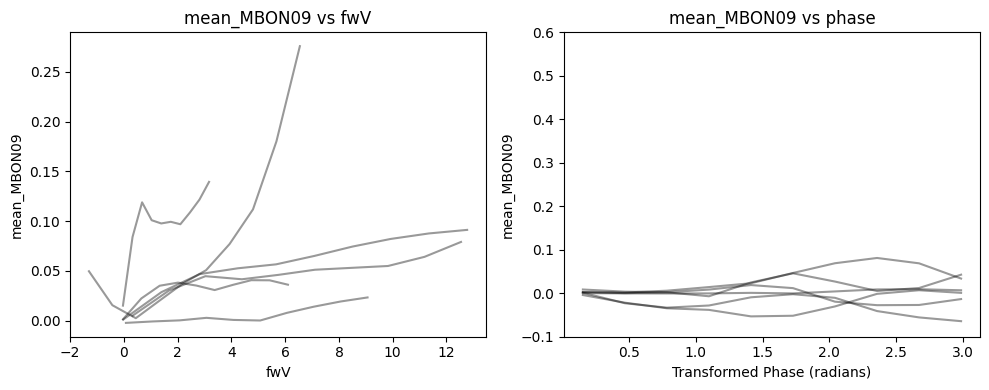

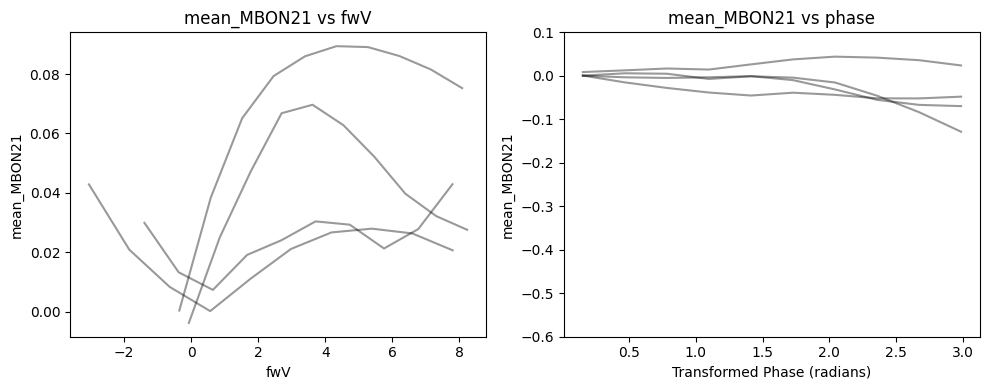

In [853]:
# single trial test
nobar_df_copy = no_bar_filtered[no_bar_filtered.net_motion_state==1].copy()
plot_tuning_curve_wrapper_3(nobar_df_copy, ['mean_MBON09',"mean_MBON21"], behavioral_vars=['fwV',  'phase'], num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\2521763126.py:1255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


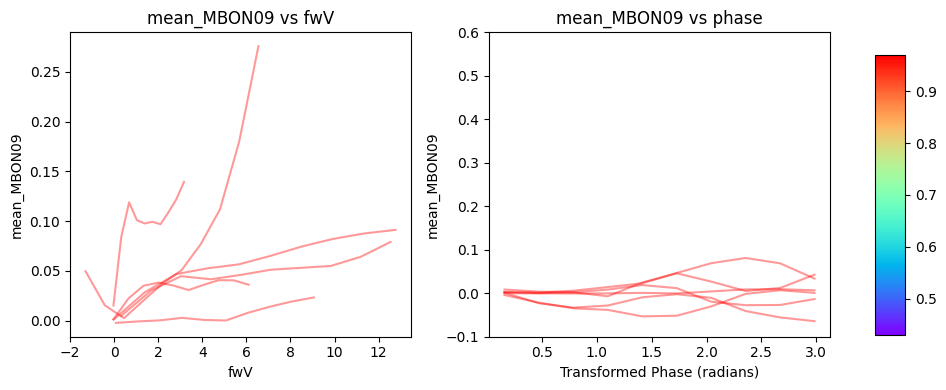

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\2521763126.py:1255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


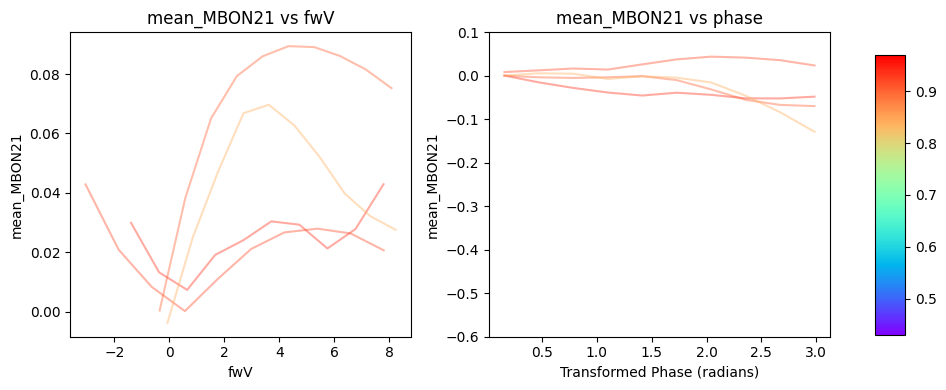

In [964]:
plot_tuning_curve_wrapper_2(nobar_df_copy, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['fwV',  'phase'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,color_map=plt.cm.rainbow)

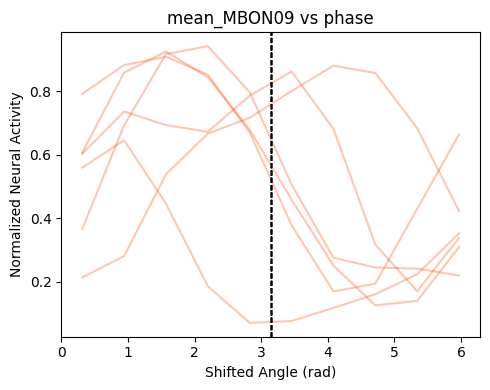

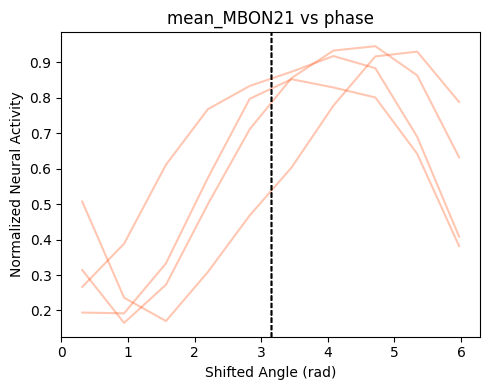

In [959]:
plot_tuning_curve_wrapper_3(nobar_df_copy, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['phase'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

### Tuning curves all

In [659]:
# save and load stuff
combined_df.to_pickle('combined_old.pkl')
combined_df_new.to_pickle('combined_new.pkl')

In [428]:
df_all = pd.concat([combined_df, combined_df_new],ignore_index=True)

##### Individual trial examine

filter out criteria:
- fragemented path (lots of stop start)
- very biasded heading, not able to cover the full 2pi
- pathes that look hard to determine the modal heading
- chronic drifting baseline

filtered out trials:
- 20220525-5_MBON09_GCAMP7f_fly2 trial 2 (okay)
- 20220621-2_MBON09_GCAMP7f_short trial 1 & 2
- 20220913-8_MBON09hDeltaB_syntGCAMP7f_fly3_short trial 1
- 0220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long trial 1 
- 20221011-3_hDeltaBMBON09_syntGCAMP7f_odor trial 4
- 20230426-8_MBON09hDeltaB_syntGCAMP7f_long_nojump_fly4 no MBON09 ROI
- 20230511-2_MBON09hDeltaB_syntGCAMP7f_long_nojump 1 & 2 & 3
- 20230511-3_MBON09hDeltaB_syntGCAMP7f_long_jump 1 & 2
- 20230517-2_MBON09hDeltaB_syntGCAMP7f_long_nojump trial 2
- 20230517-7_MBON09_syntGCAMP7f_fly2_long_jump trial 2
- 20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor 2 & 3
- 20230608-5_MBON09hDeltaB_GCAMP7f_odor_short_benzylad 1
- 20230710-1_MBON09_GCAMP7f_odor_apple_width30 2
- 20230714-1_MBON09hDeltaB_syntGCAMP7f_odor_apple_width10_long 1 & 2
- 20230725-1_MBON09_GCAMP7f_odor_apple_sparsegrid 1 ?
- 20230726-1_MBON09_GCAMP7f_odor_apple_sparsegrid 1 & 2 & 3
- 20230726-2_MBON09_GCAMP7f_odor_apple_densegrid 1 & 2
- 20230901-2_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis 1
- 20230901-3_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis_flipsign 1
- 20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid [processing error check again]
- 20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi 1
- 20230927-6_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi 1 & 2
- 20230928-1_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi 1
- 20230928-2_MBON09hDeltaB_syntGCAMP7f_50secodor_100isi 1

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\2728900859.py:1088: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


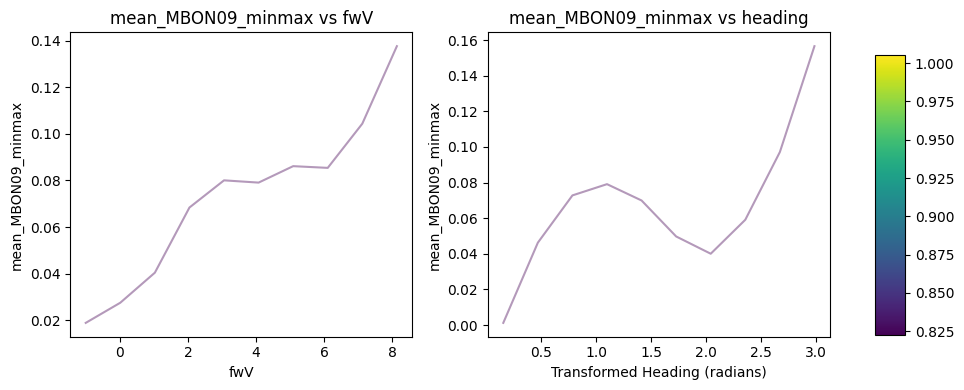

In [827]:
test = combined_df[(combined_df['folder_name'] == '20230928-3_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi') ]#& (combined_df['trialid'] == 5)]
plot_tuning_curve_wrapper_2(test, ["mean_MBON09_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

##### Test filtering by trials

In [898]:


# Define the folder_name and trialid combinations to filter out.
# For folders with multiple trial IDs, list them as integers.
# For the one folder without a specified trialid (assumed to be all), we use None.
filter_conditions = {
    "20220621-2_MBON09_GCAMP7f_short": [2],
    "20220913-8_MBON09hDeltaB_syntGCAMP7f_fly3_short": [1],
    "0220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long": [1],
    "20221011-3_hDeltaBMBON09_syntGCAMP7f_odor": [4],
    "20230426-8_MBON09hDeltaB_syntGCAMP7f_long_nojump_fly4": [1],
    "20230511-2_MBON09hDeltaB_syntGCAMP7f_long_nojump": [1, 2, 3],
    "20230511-3_MBON09hDeltaB_syntGCAMP7f_long_jump": [1, 2],
    "20230517-2_MBON09hDeltaB_syntGCAMP7f_long_nojump": [2],
    "20230517-7_MBON09_syntGCAMP7f_fly2_long_jump": [2],
    "20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor": [2, 3],
    "20230608-5_MBON09hDeltaB_GCAMP7f_odor_short_benzylad": [1],
    "20230710-1_MBON09_GCAMP7f_odor_apple_width30": [2],
    "20230714-1_MBON09hDeltaB_syntGCAMP7f_odor_apple_width10_long": [1, 2],
    "20230725-1_MBON09_GCAMP7f_odor_apple_sparsegrid": [1],  # assuming trial 1
    "20230726-1_MBON09_GCAMP7f_odor_apple_sparsegrid": [1, 2, 3],
    "20230726-2_MBON09_GCAMP7f_odor_apple_densegrid": [1, 2],
    "20230901-2_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis": [1],
    "20230901-3_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis_flipsign": [1],
    #"20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid": None,  # filter out all trials for this folder
    "20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi": [1],
    "20230927-6_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi": [1, 2],
    "20230928-1_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi": [1],
    "20230928-2_MBON09hDeltaB_syntGCAMP7f_50secodor_100isi": [1],
    '20231107-1_MBON21_GCAMP7f_odor_5dur25isi': [3],
}

# Start with a mask that selects all rows.
mask = pd.Series(True, index=combined_df.index)

# Update the mask for each condition so that the specified folder and trialid rows are excluded.
for folder, trial_ids in filter_conditions.items():
    if trial_ids is None:
        # Exclude all rows with this folder_name
        mask &= (combined_df["folder_name"] != folder)
    else:
        # Exclude rows where both folder_name and trialid match the condition
        mask &= ~((combined_df["folder_name"] == folder) &
                  (combined_df["trialid"].isin(trial_ids)))

# Apply the mask to filter out the unwanted rows.
combined_df_filtered = combined_df[mask]




0.42961486791037745
0.9693719535869026


C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\4217834764.py:1111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


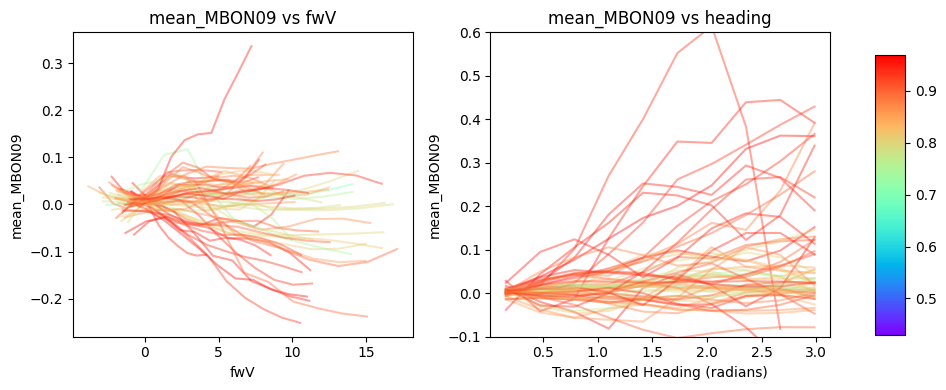

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\4217834764.py:1111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


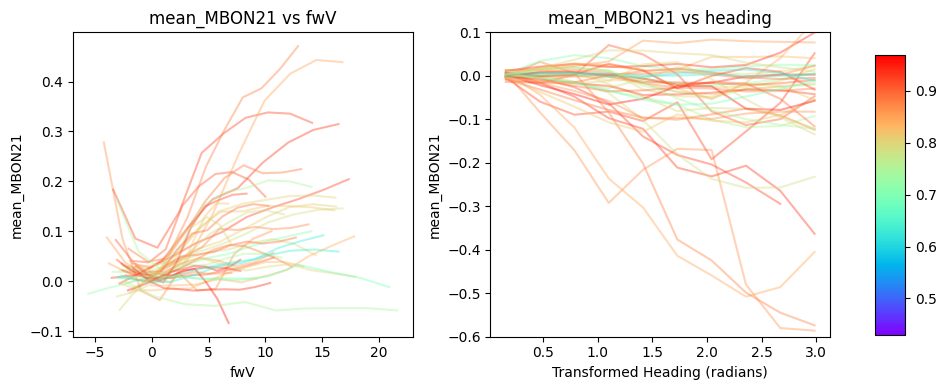

In [908]:
#combined_df_filtered = combined_df[~((combined_df['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df['trialid'] == 3))]

combined_df_copy = combined_df_filtered[combined_df_filtered.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,color_map=plt.cm.rainbow)

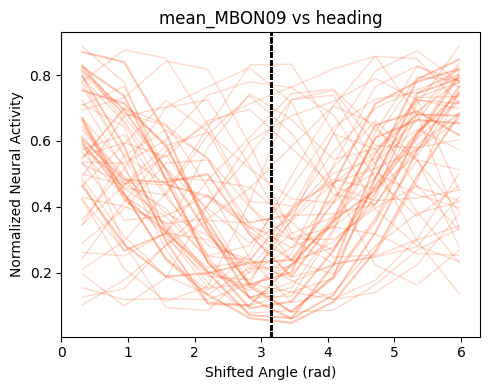

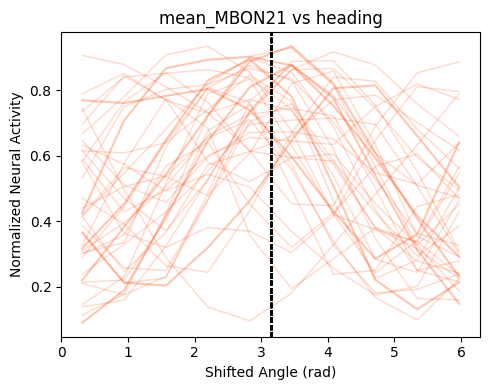

In [956]:
plot_tuning_curve_wrapper_3(combined_df_copy, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

##### Test filtering just by motion state, min_max normalization

In [ ]:
combined_df_filtered = combined_df[~((combined_df['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df['trialid'] == 3))]

combined_df_copy = combined_df_filtered[combined_df_filtered.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09_minmax", "mean_MBON21_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

##### Test filtering by avg rho, motion state, min_max normalization

In [ ]:
combined_df['trial_avg'] = combined_df.groupby(['folder_name', 'trialid'])['rho_t'].transform('mean')

# Step 2: Filter out rows where the trial average is below 0.7.
combined_df_filtered = combined_df[combined_df['trial_avg'] >= 0.8].drop(columns='trial_avg')
combined_df_filtered_2 = combined_df_filtered[~((combined_df_filtered['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df_filtered['trialid'] == 3))]
combined_df_copy = combined_df_filtered_2[combined_df_filtered.net_motion_state==1].copy()


In [ ]:


plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09_minmax", "mean_MBON21_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

##### Test filtering by avg fwV, motion state, min_max normalization

In [667]:
combined_df['trial_avg'] = combined_df.groupby(['folder_name', 'trialid'])['fwV'].transform('mean')
#combined_df.trial_avg.unique()
# Step 2: Filter out rows where the trial average is below 0.7.
combined_df_filtered = combined_df[combined_df['trial_avg'] >= 1.5].drop(columns='trial_avg')
combined_df_filtered_2 = combined_df_filtered[~((combined_df_filtered['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df_filtered['trialid'] == 3))]
combined_df_copy = combined_df_filtered_2[combined_df_filtered.net_motion_state==1].copy()

In [ ]:

plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09_minmax", "mean_MBON21_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

##### Test filtering by avg odor state, motion state, min_max normalization

In [ ]:
combined_df['trial_avg_odor'] = combined_df.groupby(['folder_name', 'trialid'])['odor_state'].transform('mean')

# Step 2: Filter out trials where either average is below the threshold.
# Keep only rows where trial_avg_rho_t is at least 0.7 and trial_avg_fwV is at least 1.5.
combined_df_filtered = combined_df[combined_df['trial_avg_odor'] <0.3
].drop(columns=[ 'trial_avg_odor'])
#combined_df_filtered = combined_df[~(combined_df['trial_avg'] >= 0.2)].drop(columns='trial_avg')
combined_df_filtered_2 = combined_df_filtered[~((combined_df_filtered['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df_filtered['trialid'] == 3))]
combined_df_copy = combined_df_filtered_2[combined_df_filtered.net_motion_state==1].copy()

In [ ]:

plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09_minmax", "mean_MBON21_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

##### Test filtering by avg fwV, avg rho motion state, min_max normalization

In [735]:
combined_df['trial_avg_rho_t'] = combined_df.groupby(['folder_name', 'trialid'])['rho_t'].transform('mean')
combined_df['trial_avg_fwV'] = combined_df.groupby(['folder_name', 'trialid'])['fwV'].transform('mean')

# Step 2: Filter out trials where either average is below the threshold.
# Keep only rows where trial_avg_rho_t is at least 0.7 and trial_avg_fwV is at least 1.5.
combined_df_filtered = combined_df[
    ~((combined_df['trial_avg_rho_t'] < 0.7) | (combined_df['trial_avg_fwV'] < 1.5))
].drop(columns=['trial_avg_rho_t', 'trial_avg_fwV'])
combined_df_filtered_2 = combined_df_filtered[~((combined_df_filtered['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df_filtered['trialid'] == 3))]
combined_df_copy = combined_df_filtered_2[combined_df_filtered.net_motion_state==1].copy()

In [ ]:
plot_tuning_curve_wrapper_2(combined_df_copy, ["mean_MBON09_minmax", "mean_MBON21_minmax"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,color_map=plt.cm.viridis)

#### examine hDeltaB

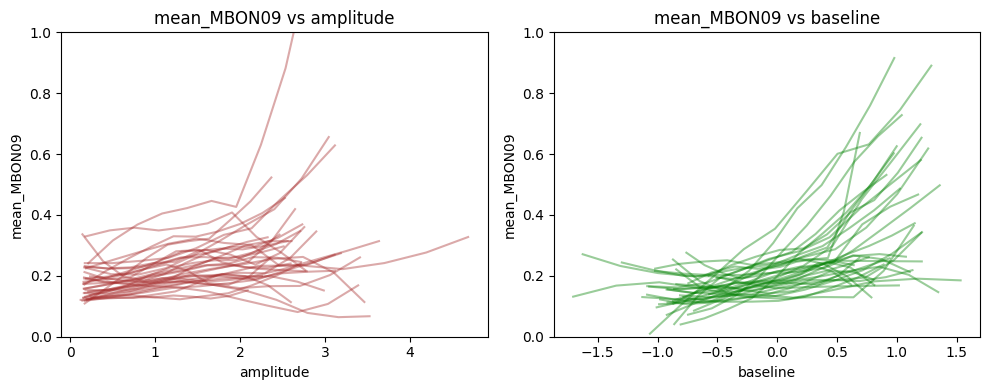

In [976]:
combined_df_filtered = combined_df[~((combined_df['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df['trialid'] == 3))]
combined_df_copy = combined_df_filtered[combined_df_filtered.net_motion_state==1].copy()

plot_tuning_curve_wrapper_3(combined_df_copy, [ "mean_MBON09"], behavioral_vars=['amplitude',  'baseline'],  
                              num_bins=10, percentile_low=1, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

In [ ]:

def count_nonzero_avg_conditions(df,meancol = 'mean_MBON09'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name']).agg({
        'amplitude': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['amplitude'] > 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_filtered)
print(count)


In [ ]:
combined_df_filtered = combined_df[~((combined_df['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df['trialid'] == 3))]
combined_df_copy = combined_df_filtered[combined_df_filtered.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(combined_df_copy, ["amplitude","baseline"], behavioral_vars=['fwV',  'heading',"phase"],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

#### Examine FB4R

In [350]:




def get_roi_seq_2(roi_df, trial_number):
    roi_df['trialNum'] = roi_df['trialNum'].apply(lambda x: x[0][0])
    
    # Filter the DataFrame to only include rows with the specified trial number
    roi_df = roi_df[roi_df['trialNum'] == trial_number].reset_index(drop=True)
    
    roi_names = roi_df['roiName'].apply(lambda x: x[0])
    roi_hdeltab = roi_names[roi_names.str.contains('hDeltaB', case=False)]
    hdeltab_index = roi_hdeltab.index
    roi_epg = roi_names[roi_names.str.contains('EPG')]
    epg_index = roi_epg.index
    roi_fr1 = roi_names[roi_names.str.contains('FR1') & ~roi_names.str.contains('CRE')]
    fr1_index = roi_fr1.index
    roi_fb4r = roi_names[roi_names.str.contains('FB4R') & ~roi_names.str.contains('CRE')]
    fb4r_index = roi_fb4r.index
    
    hdeltab_seq = roi_hdeltab.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    
    if epg_index.size > 0:
        epg_seq = roi_epg.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        epg_seq = None 
    
    if fr1_index.size > 0:
        fr1_seq = roi_fr1.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fr1_seq = None 
    if fb4r_index.size > 0:
        fb4r_seq = roi_fb4r.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fb4r_seq = None 
    return np.array(roi_names), hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_seq, epg_seq, fr1_seq,fb4r_seq

def sort_rois(dff_tosort, roi_names, query_idx, query_seq):
    sorting_indices = np.argsort(query_seq)
    #print(sorting_indices)
    segment_to_sort = dff_tosort[query_idx]
    #print(segment_to_sort)
    sorted_dff_rois = segment_to_sort[sorting_indices]
    dff_tosort[query_idx] = sorted_dff_rois
    roi_names_sort = roi_names[query_idx]
    roi_names_sort = roi_names_sort[sorting_indices]
    roi_names[query_idx] = roi_names_sort

def make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence,fr1_sequence,fb4r_sequence):
    #TODO
    if hdeltab_index.size > 0:
        #print(1)
        sort_rois(dff_all_rois, roi_names, hdeltab_index, hdeltab_sequence)
    else:
        pass
    if epg_index.size > 0:
        sort_rois(dff_all_rois, roi_names, epg_index, epg_sequence)
    else:
        pass
    if fr1_index.size > 0:
        sort_rois(dff_all_rois, roi_names, fr1_index, fr1_sequence)
    else:
        pass
    if fb4r_index.size > 0:
        sort_rois(dff_all_rois, roi_names, fb4r_index, fb4r_sequence)
    else:
        pass
    # Create a new DataFrame for the reordered data
    neural_df = pd.DataFrame()
    neural_df['time'] = np.squeeze(dff_time)
    #print(len(dff_all_rois))
    # Add each sorted ROI data to the DataFrame with the specified naming convention
    for i, roi_data in enumerate(dff_all_rois):
        column_name =  roi_names[i] # Generate column name starting from hDeltaB1
        neural_df[column_name] = np.squeeze(roi_data)
    # Identify columns where all values are 0
    cols_to_drop = [col for col in neural_df.columns if neural_df[col].eq(0).all()]
    
    # Drop these columns from the DataFrame
    neural_df.drop(columns=cols_to_drop, inplace=True)
    return neural_df



In [359]:
def make_merged_df_fb4r(example_path_data,  trial_num):
    # Load data and preprocess
    print(example_path_data)
    is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data, trial_num)
    behav_df = make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
    behav_df = reconstruct_path(behav_df, ball_d=9)
    # calculate straightness
    behav_df = calculate_theta_g_rho(behav_df)
    # odor related variable processing
    if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
        behav_df = compute_event_metrics_3(behav_df)
        #behav_df = compute_event_metrics(behav_df)
    roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_sequence = get_roi_seq_2(roi_df)
    dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
    neural_df = make_df_neural(
        dff_all_rois,
        dff_time,
        roi_names,
        hdeltab_index,
        epg_index,
        fr1_index,
        fb4r_index,
        hdeltab_sequence,
        epg_sequence,
        fr1_sequence,
        fb4r_sequence
    )
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
        #print(1)
        roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2)
        neural_df,paramfit_df = fit_sinusoid(neural_df,roi_mtx)
    neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    neural_df = mean_FB4R(neural_df)
    merged_df = merge_dataframes(behav_df, neural_df)
    return merged_df

def process_all_trials_fb4r(base_path, odor_threshold=5, time_interval_threshold=16, k=8, window_size=30):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path
    for fly_folder in os.listdir(base_path):
        fly_folder_path = os.path.join(base_path, fly_folder)

        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path +"/data/"

        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking files like dff_raw_trialx.mat
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff raw trial\d+\.mat", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            #try:
            # Load the intermediate MAT file
            merged_df = make_merged_df_fb4r(data_path, trial_num)
            # Combine behavioral and neural dataframes

            # Add flyid and trialid columns
            merged_df["flyid"] = flyid
            merged_df["trialid"] = trial_num
            merged_df["folder_name"] = fly_folder

            # Append to all_data
            all_data.append(merged_df)

            #except Exception as e:
                #print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None

In [ ]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/FB4R_imaging/"
FB4R_df = process_all_trials_fb4r(base_path)

In [ ]:
FB4R_df.folder_name.unique()

In [ ]:
test = FB4R_df[(FB4R_df['folder_name'] == '20230919-3_FB4R_GCAMP7f_noodor') & (FB4R_df['trialid'] == 2)]
test_copy = test[test.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(test_copy, ["mean_FB4R"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

In [ ]:
#FB4R_df_filtered = FB4R_df[~((FB4R_df['folder_name'] == '20230831-2_FB4R_syntGCAMP7f_sparse_time_fly2') & (FB4R_df['trialid'] == 1))]
#FB4R_df_filtered_2 = FB4R_df_filtered[~((FB4R_df_filtered['folder_name'] == '20230919-3_FB4R_GCAMP7f_noodor') & (FB4R_df_filtered['trialid'] == 2))]
FB4R_df_copy = FB4R_df[FB4R_df.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(FB4R_df_copy, ["mean_FB4R"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True)

#### MBON09/21 response colored by prior stimulus interval

In [979]:
combined_df_filtered = combined_df[~combined_df['folder_name'].str.contains("sigmoid", na=False)].reset_index(drop=True)

In [980]:

def count_nonzero_avg_conditions(df,meancol = 'mean_MBON09'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name','trialid']).agg({
        'odor_state': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['odor_state'] != 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_filtered)
print(count)


58


In [ ]:
plot_neural_activity(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=37,bounds=[10, 50, 100],percentile_range=[0, 95])

In [ ]:
plot_neural_activity(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"],  pre_window_size=20, post_window_size=37,bounds=[5, 25,50],is_onset=False,percentile_range=[0, 99])

#### MBON09/21 response colored by prior duration

In [ ]:
combined_df.columns

In [ ]:
plot_neural_activity(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=37,plot_kw = 'prior_event_duration',bounds=[5, 20,60],percentile_range=[0, 99])

In [ ]:
plot_neural_activity(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=37,plot_kw = 'prior_event_duration',is_onset=False,bounds=[10,  50],percentile_range=[0, 98])

#### MBON09/21 response colored by novelty score

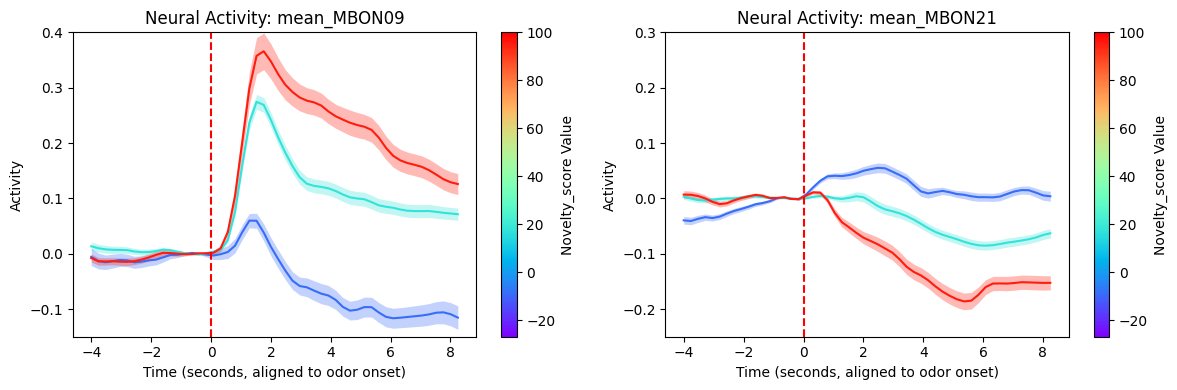

In [981]:
plot_neural_activity_zero(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=True, bounds=[0,50],percentile_range=[1, 95],baseline_duration=1,onset_shift=0.8)

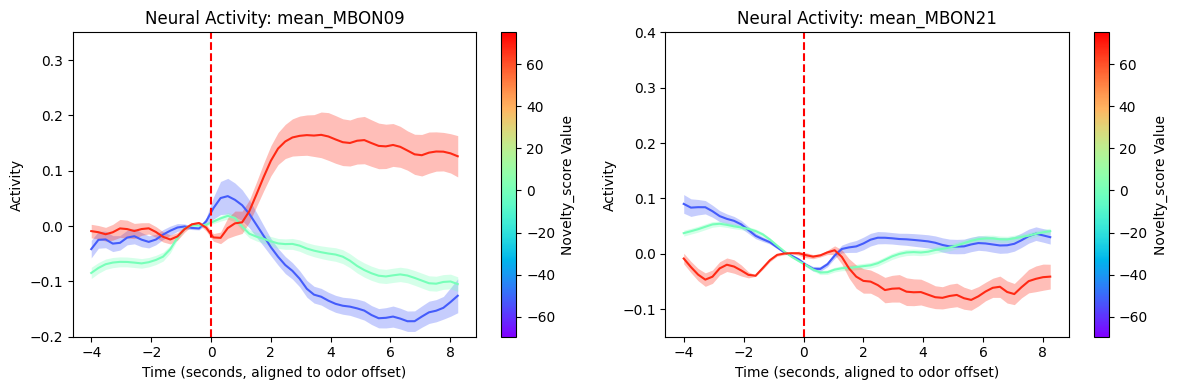

In [982]:
plot_neural_activity_zero(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=False, bounds=[-30,30],percentile_range=[1, 98],baseline_duration=1,onset_shift=0.8)

#### hDeltaB amplitude and mean responses colored by interval

In [ ]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],bounds=[10, 20, 50, 100])

#### hDeltaB amplitude and mean responses colored by duration

In [ ]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],plot_kw = 'duration',bounds=[5, 10, 25,60])

#### FwV and yawV responses

In [ ]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1,velocity_threshold=5,bounds=[10, 25, 100, 200])

In [ ]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1.5,plot_kw = 'duration', velocity_threshold=5,bounds=[5, 10, 25, 50])

#### DANs

In [ ]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/DAN_imaging/old acquisition/"
combined_df_DAN = process_all_trials(base_path)

In [987]:
combined_df_DAN.folder_name.unique()

array(['20211228-5_20211228_MB441B_age1',
       '20220525-8_MB312C_GCAMP7f_fly2', '20220525-9_MB312C_GCAMP7f_fly2',
       '20220607-5_MB312C_GCAMP7f_fly2', '20220607-7_MB312C_GCAMP7f_fly2',
       '20220608-9_MB312C_GCAMP7f', '20220616-2_MB441B_GCAMP7f_short',
       '20220616-3_MB441B_GCAMP7f_long',
       '20220628-2_MB441B_GCAMP7f_short',
       '20220628-3_MB441B_GCAMP7f_long'], dtype=object)

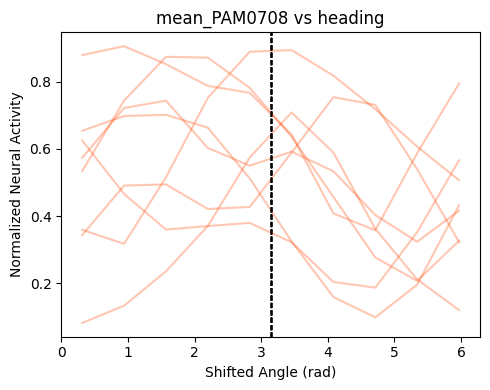

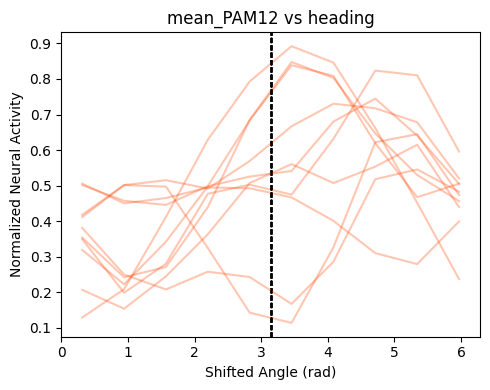

In [986]:
combined_df_DAN_copy = combined_df_DAN[combined_df_DAN.net_motion_state==1].copy()
plot_tuning_curve_wrapper_3(combined_df_DAN_copy, ["mean_PAM0708", "mean_PAM12"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\802480244.py:1265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


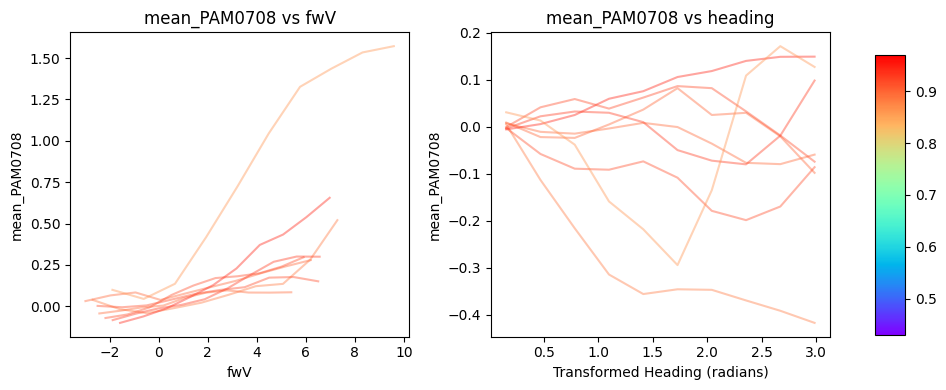

C:\Users\wilson\AppData\Local\Temp\ipykernel_8000\802480244.py:1265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


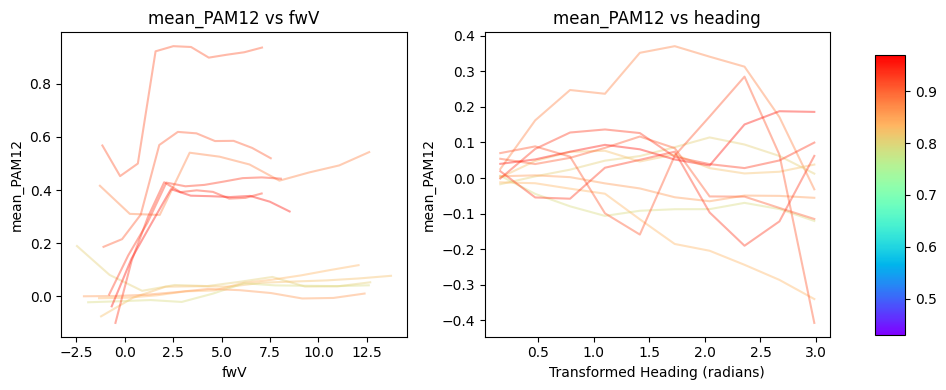

In [991]:
#combined_df_filtered = combined_df[~((combined_df['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df['trialid'] == 3))]
combined_df_DAN_copy = combined_df_DAN[combined_df_DAN.net_motion_state==1].copy()

plot_tuning_curve_wrapper_2(combined_df_DAN_copy, ["mean_PAM0708", "mean_PAM12"], behavioral_vars=['fwV',  'heading'],  
                              num_bins=10, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,color_map=plt.cm.rainbow)

In [ ]:

def count_nonzero_avg_conditions(df,meancol = 'mean_PAM12'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name']).agg({
        'absyawV': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['absyawV'] > 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_DAN)
print(count)


In [ ]:
plot_neural_activity(combined_df_DAN, plot_columns=["mean_PAM0708","mean_PAM12"], pre_window_size=20, post_window_size=37,bounds=[20,40],percentile_range=[0, 100])